# **Import Library dan Dataset**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import joblib
import streamlit as st
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
df = pd.read_excel("Online Retail.xlsx")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


# **Preprocessing & EDA**

In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
# Drop rows with missing CustomerID (tanpa ID tidak bisa dianalisis per customer)
df.dropna(subset=['CustomerID'], inplace=True)

In [5]:
# Buat kolom TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [6]:
# Tentukan tanggal acuan (misalnya hari setelah transaksi terakhir)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                         # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

In [7]:
rfm.isnull().sum()

Recency      0
Frequency    0
Monetary     0
dtype: int64

In [8]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,3,176.60


c:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


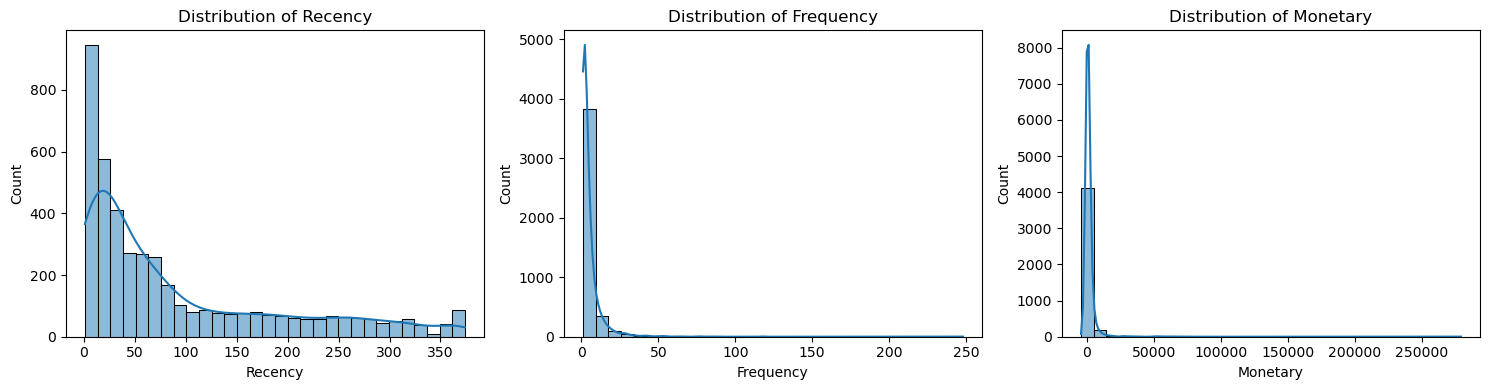

In [9]:
# Buat list kolom RFM
cols = ['Recency', 'Frequency', 'Monetary']

# Plot histogram & KDE
plt.figure(figsize=(15, 4))
for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(rfm[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [10]:
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])

c:\Anaconda\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
rfm.isnull().sum()

Recency           0
Frequency         0
Monetary          0
Monetary_log     41
Frequency_log     0
dtype: int64

In [12]:
rfm['Monetary_log'] = rfm['Monetary'].apply(lambda x: np.log1p(x) if x > 0 else 0)

In [13]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency_log', 'Monetary_log']])

c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` w

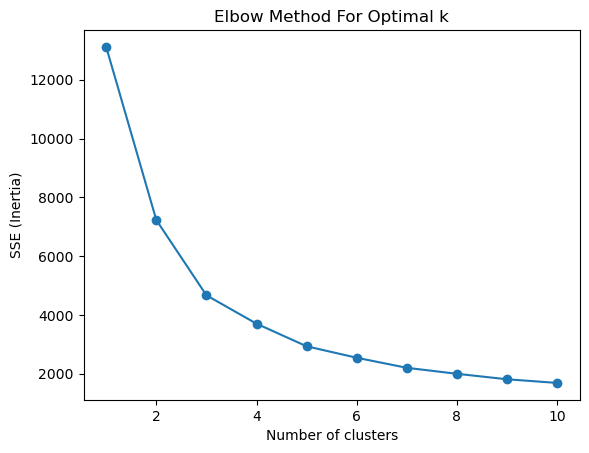

In [21]:
# Elbow method
sse = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    sse.append(km.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.show()

# **Modeling**

In [14]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

c:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
rfm.groupby('Cluster').mean().round(1)

,Recency,Frequency,Monetary,Monetary_log,Frequency_log
Cluster,,,,,
0,59.2,1.6,385.8,5.7,0.9
1,18.5,18.8,8600.3,8.5,2.8
2,262.3,1.5,334.1,5.3,0.9
3,46.0,4.8,1508.9,7.1,1.7


# **Visualisasi & Insight**

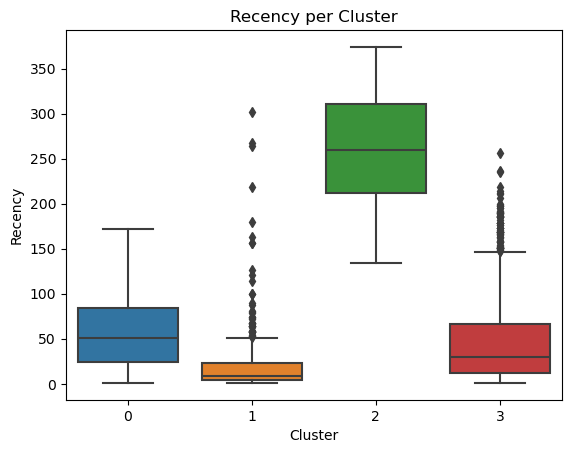

In [16]:
sns.boxplot(data=rfm, x='Cluster', y='Recency')
plt.title('Recency per Cluster')
plt.show()

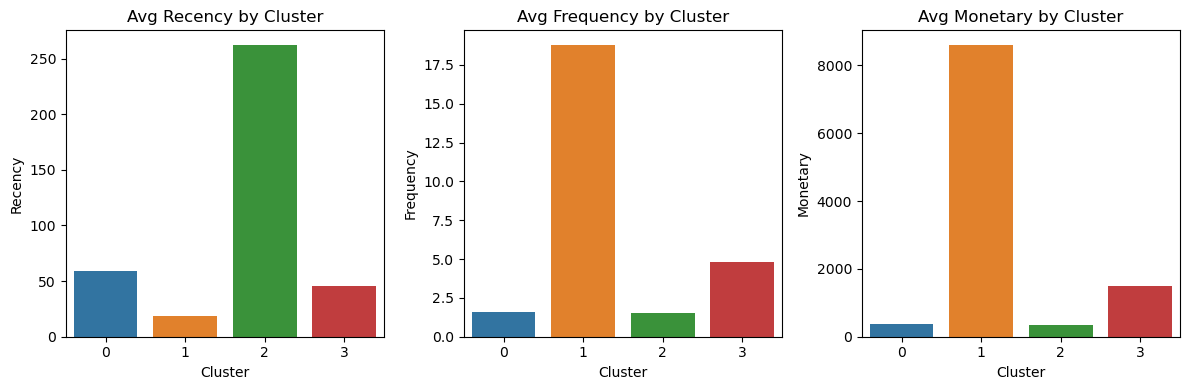

In [17]:
rfm_clustered = rfm.groupby('Cluster').mean(numeric_only=True).reset_index()

plt.figure(figsize=(12,4))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    sns.barplot(data=rfm_clustered, x='Cluster', y=col)
    plt.title(f'Avg {col} by Cluster')
plt.tight_layout()
plt.show()

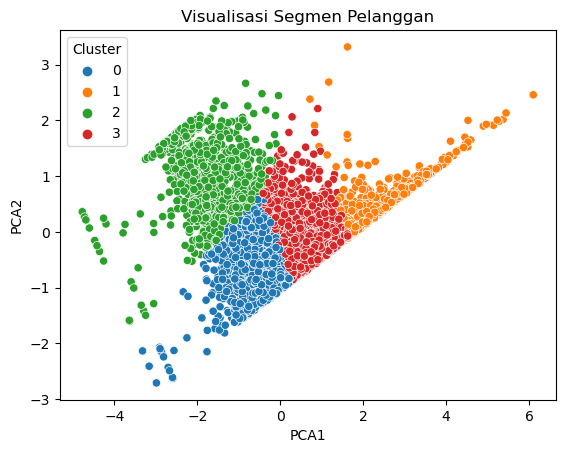

In [23]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = pca_data[:,0]
rfm['PCA2'] = pca_data[:,1]

sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
plt.title('Visualisasi Segmen Pelanggan')
plt.show()

In [19]:
segment_map = {
    0: 'Occasional Buyers',
    1: 'Loyal High-Spenders',
    2: 'Dormant Customers',
    3: 'Potential Loyalists'
}

rfm['Segment'] = rfm['Cluster'].map(segment_map)

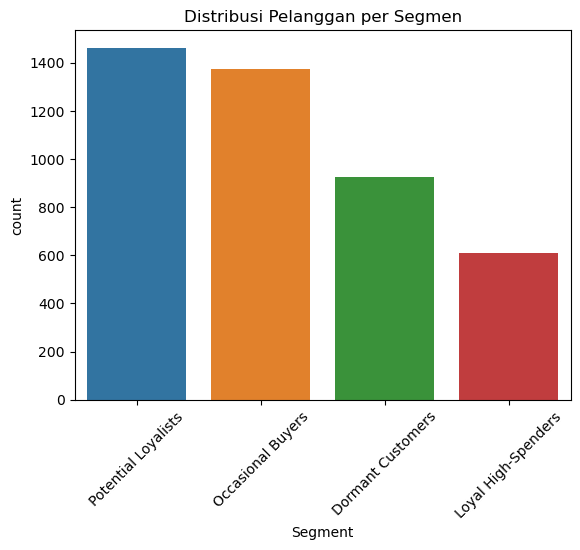

In [20]:
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribusi Pelanggan per Segmen")
plt.show()

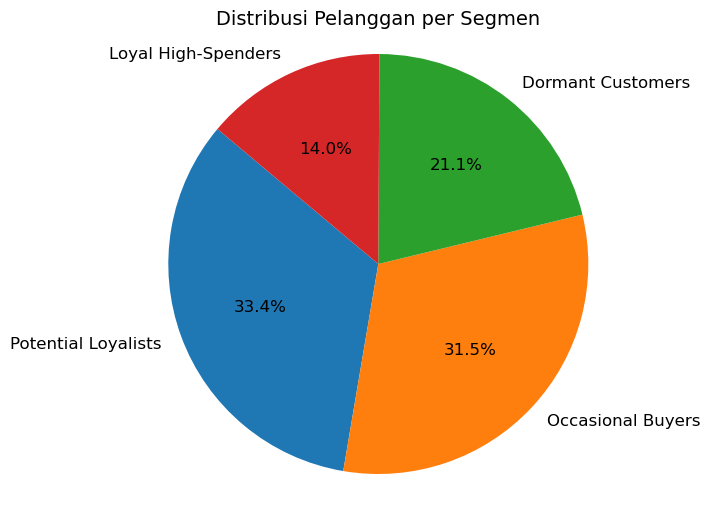

In [28]:
# Hitung proporsi segmen
segment_counts = rfm['Segment'].value_counts()
segment_labels = segment_counts.index
segment_sizes = segment_counts.values

# Buat pie chart
plt.figure(figsize=(8, 6))
plt.pie(segment_sizes, labels=segment_labels, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})
plt.title('Distribusi Pelanggan per Segmen', fontsize=14)
plt.axis('equal')
plt.show()

# **Deployment**

In [33]:
# Simpan model
joblib.dump(kmeans, 'C:\Samuel\Cust. Segmentation\customer_segmentation_app\model\kmeans_model.pkl')

# Simpan scaler
joblib.dump(scaler, 'C:\Samuel\Cust. Segmentation\customer_segmentation_app\model\scaler.pkl')

['C:\\Samuel\\Cust. Segmentation\\customer_segmentation_app\\model\\scaler.pkl']